In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Commit Patterns

### 깃헙 커밋이 가장 활발하게 일어나는 시간대는?

In [2]:
%%bigquery hourly_commit_counts
SELECT 
  EXTRACT(HOUR FROM TIMESTAMP_SECONDS(committer.date.seconds)) AS hour_of_day,
  COUNT(*) AS commit_count
FROM
  `bigquery-public-data.github_repos.commits`
GROUP BY
  hour_of_day
ORDER BY
  hour_of_day;

Query is running:   0%|          |

Downloading:   0%|          |

In [3]:
all_hours = pd.DataFrame({'hour_of_day': range(1,24)})
hourly_commit_counts = pd.merge(all_hours, hourly_commit_counts, on='hour_of_day', how='left')

hourly_commit_counts['commit_count'] = hourly_commit_counts['commit_count'].fillna(0)

In [4]:
hourly_commit_counts

,hour_of_day,commit_count
0,1,7674983
1,2,7267032
2,3,7003084
3,4,6658097
4,5,6790185
5,6,7379197
6,7,8516162
7,8,9984912
8,9,11395872
9,10,11022905


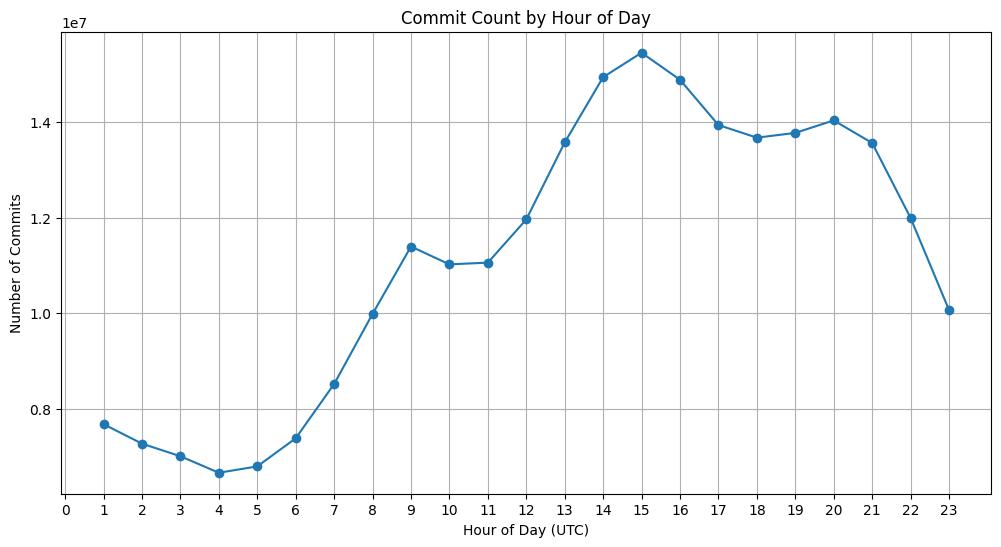

In [5]:
plt.figure(figsize=(12, 6))
plt.plot(hourly_commit_counts['hour_of_day'], hourly_commit_counts['commit_count'], marker='o')
plt.title('Commit Count by Hour of Day')
plt.xlabel('Hour of Day (UTC)')
plt.ylabel('Number of Commits')
plt.grid(True)
plt.xticks(range(0, 24))
plt.show()

위 그래프는 UTC 기준으로 발생한 시점을 보여주기 때문에 커미터의 시간대를 고려하지 않음

따라서 로컬 시간대로 변환하는 쿼리로 재진행:

In [6]:
%%bigquery hourly_commit_counts_local
SELECT 
  EXTRACT(HOUR FROM TIMESTAMP_SECONDS(committer.date.seconds + committer.tz_offset * 60)) AS local_hour_of_day,
  COUNT(*) AS commit_count
FROM
  `bigquery-public-data.github_repos.commits`
GROUP BY
  local_hour_of_day
ORDER BY
  local_hour_of_day;

Query is running:   0%|          |

Downloading:   0%|          |

In [7]:
all_hours = pd.DataFrame({'local_hour_of_day': range(0, 24)})
hourly_commit_counts_local = pd.merge(all_hours, hourly_commit_counts_local, on='local_hour_of_day', how='left')

hourly_commit_counts_local['commit_count'] = hourly_commit_counts_local['commit_count'].fillna(0)
hourly_commit_counts_local.head()

,local_hour_of_day,commit_count
0,0,8838926
1,1,5854315
2,2,4100412
3,3,3063010
4,4,2467000


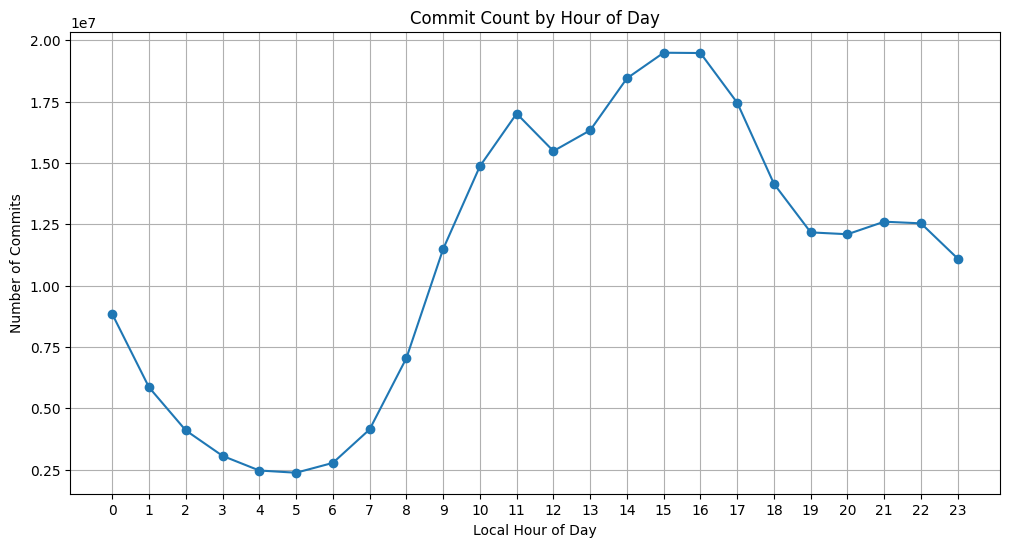

In [8]:
plt.figure(figsize=(12, 6))
plt.plot(hourly_commit_counts_local['local_hour_of_day'], hourly_commit_counts_local['commit_count'], marker='o')
plt.title('Commit Count by Hour of Day')
plt.xlabel('Local Hour of Day')
plt.ylabel('Number of Commits')
plt.grid(True)
plt.xticks(range(0, 24))
plt.show()

### 깃헙 커밋이 가장 활발하게 일어나는 달은?

In [9]:
%%bigquery commits_by_month_df
SELECT
  FORMAT_TIMESTAMP('%Y-%m', TIMESTAMP_SECONDS(committer.date.seconds)) AS commit_month,
  COUNT(*) AS commit_count
FROM
  `bigquery-public-data.github_repos.commits`
GROUP BY
  commit_month
ORDER BY
  commit_month

Query is running:   0%|          |

Downloading:   0%|          |

In [10]:
commits_by_month_df.commit_month.tail(10)

829    2088-01
830    2088-11
831    2099-05
832    2099-06
833    2104-03
834    2104-11
835    2107-11
836    2116-03
837    2184-06
838    2245-02
Name: commit_month, dtype: object

미래의 날짜 제외하는 쿼리로 재진행:

In [11]:
%%bigquery commits_by_month_df2
SELECT
  FORMAT_TIMESTAMP('%Y-%m', TIMESTAMP_SECONDS(committer.date.seconds)) AS commit_month,
  COUNT(*) AS commit_count
FROM
  `bigquery-public-data.github_repos.commits`
WHERE
  TIMESTAMP_SECONDS(committer.date.seconds) <= CURRENT_TIMESTAMP()
GROUP BY
  commit_month
ORDER BY
  commit_month

Query is running:   0%|          |

Downloading:   0%|          |

In [12]:
commits_by_month_df2['month'] = commits_by_month_df2['commit_month'].str[-2:]
commits_aggregated = commits_by_month_df2.groupby('month')['commit_count'].sum().reset_index()

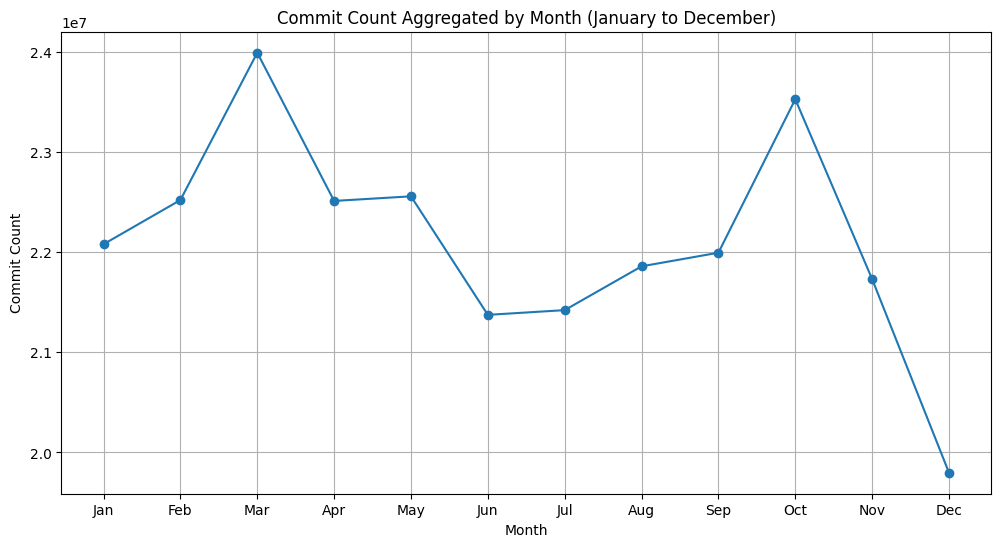

In [13]:
plt.figure(figsize=(12, 6))
plt.plot(commits_aggregated['month'], commits_aggregated['commit_count'], marker='o')
plt.title('Commit Count Aggregated by Month (January to December)')
plt.xlabel('Month')
plt.ylabel('Commit Count')
plt.grid(True)
plt.xticks(range(12), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.show()

## 대륙별 커밋 수

데이터셋에 location 정보가 없는 관계로 timezone offset 정보를 이용해 임의로 대륙을 분류

In [14]:
%%bigquery commits_by_continent_df
SELECT
  CASE
    WHEN committer.tz_offset BETWEEN -600 AND -300 THEN 'North America'
    WHEN committer.tz_offset BETWEEN -240 AND 60 THEN 'South America'
    WHEN committer.tz_offset BETWEEN 0 AND 180 THEN 'Europe/Africa'
    WHEN committer.tz_offset BETWEEN 180 AND 420 THEN 'Asia'
    WHEN committer.tz_offset >= 420 THEN 'Oceania'
    ELSE 'Unknown'
  END AS continent,
  COUNT(*) AS commit_count
FROM
  `bigquery-public-data.github_repos.commits`
GROUP BY
  continent
ORDER BY
  commit_count DESC

Query is running:   0%|          |

Downloading:   0%|          |

In [15]:
commits_by_continent_df.head()

,continent,commit_count
0,South America,113411759
1,North America,62177660
2,Europe/Africa,54845450
3,Oceania,25704003
4,Asia,9187240


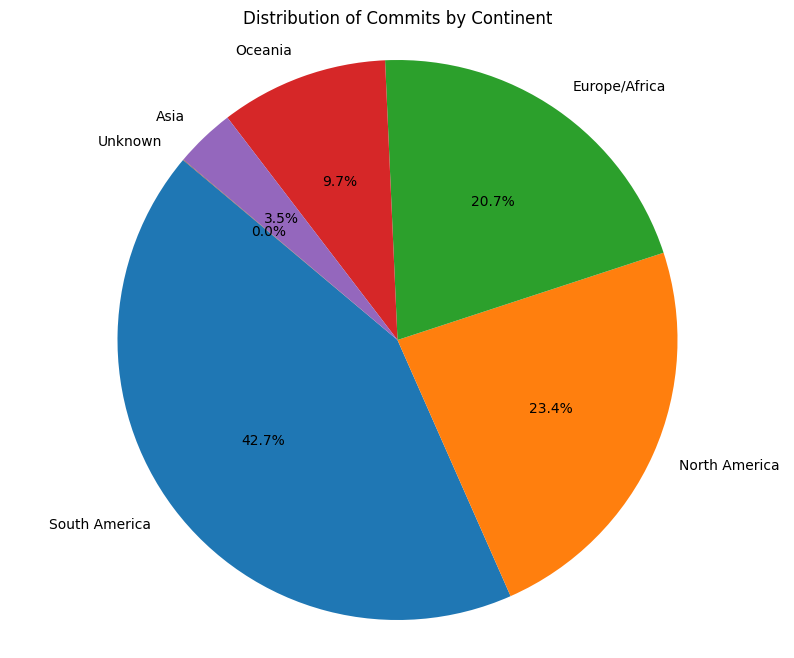

In [16]:
plt.figure(figsize=(10, 8))
plt.pie(commits_by_continent_df['commit_count'], labels=commits_by_continent_df['continent'], autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Commits by Continent')
plt.axis('equal') 
plt.show()

## 대륙별 월간 커밋 수

In [17]:
%%bigquery commits_by_month_north_america_df
SELECT
  FORMAT_TIMESTAMP('%m', TIMESTAMP_ADD(TIMESTAMP_SECONDS(committer.date.seconds), INTERVAL committer.tz_offset MINUTE)) AS commit_month,
  COUNT(*) AS commit_count
FROM
  `bigquery-public-data.github_repos.commits`
WHERE
  TIMESTAMP_ADD(TIMESTAMP_SECONDS(committer.date.seconds), INTERVAL committer.tz_offset MINUTE) <= CURRENT_TIMESTAMP()
  AND committer.tz_offset BETWEEN -600 AND -300  -- North American time zones range
GROUP BY
  commit_month
ORDER BY
  commit_month

Query is running:   0%|          |

Downloading:   0%|          |

In [18]:
commits_by_month_north_america_df

,commit_month,commit_count
0,01,6940793
1,02,7339854
2,03,5484631
3,04,4332348
4,05,4312013
5,06,4057681
6,07,4075543
7,08,4249955
8,09,4121389
9,10,4825143


### 예. North America
북미 대륙의 월간 커밋 수 플롯:

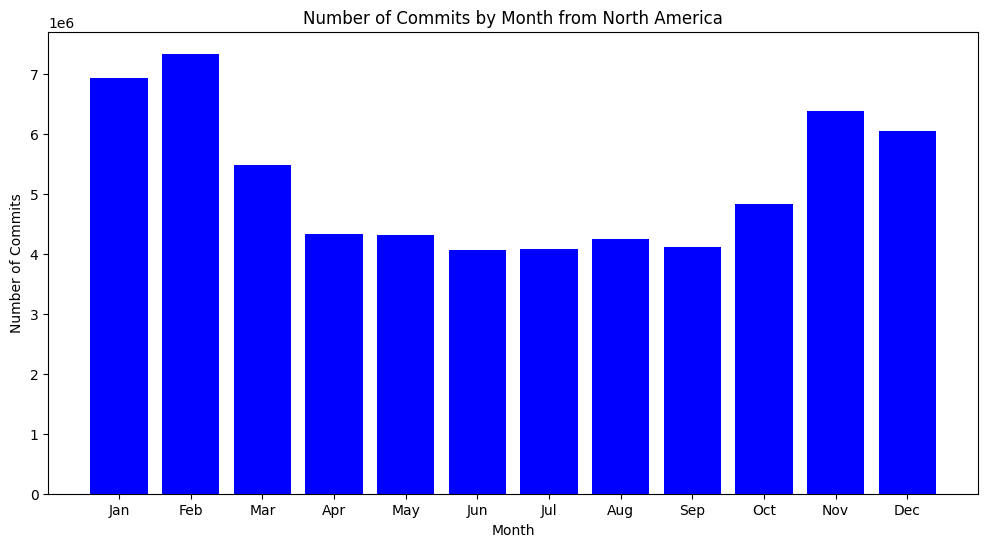

In [19]:
plt.figure(figsize=(12, 6))
plt.bar(commits_by_month_north_america_df['commit_month'], commits_by_month_north_america_df['commit_count'], color='blue')
plt.title('Number of Commits by Month from North America')
plt.xlabel('Month')
plt.ylabel('Number of Commits')
plt.xticks(range(12), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.show()

### 예. Europe
유럽 대륙의 월간 커밋 수 플롯:

In [20]:
%%bigquery commits_by_month_europe_df
# Europe
SELECT
  FORMAT_TIMESTAMP('%m', TIMESTAMP_ADD(TIMESTAMP_SECONDS(committer.date.seconds), INTERVAL committer.tz_offset MINUTE)) AS commit_month,
  COUNT(*) AS commit_count
FROM
  `bigquery-public-data.github_repos.commits`
WHERE
  TIMESTAMP_ADD(TIMESTAMP_SECONDS(committer.date.seconds), INTERVAL committer.tz_offset MINUTE) <= CURRENT_TIMESTAMP()
  AND committer.tz_offset BETWEEN 0 AND 240  -- European time zones range
GROUP BY
  commit_month
ORDER BY
  commit_month

Query is running:   0%|          |

Downloading:   0%|          |

In [22]:
commits_by_month_europe_df

,commit_month,commit_count
0,01,12059627
1,02,12245222
2,03,13074297
3,04,12006040
4,05,12074115
5,06,11417423
6,07,11401411
7,08,11552042
8,09,11993799
9,10,12523137


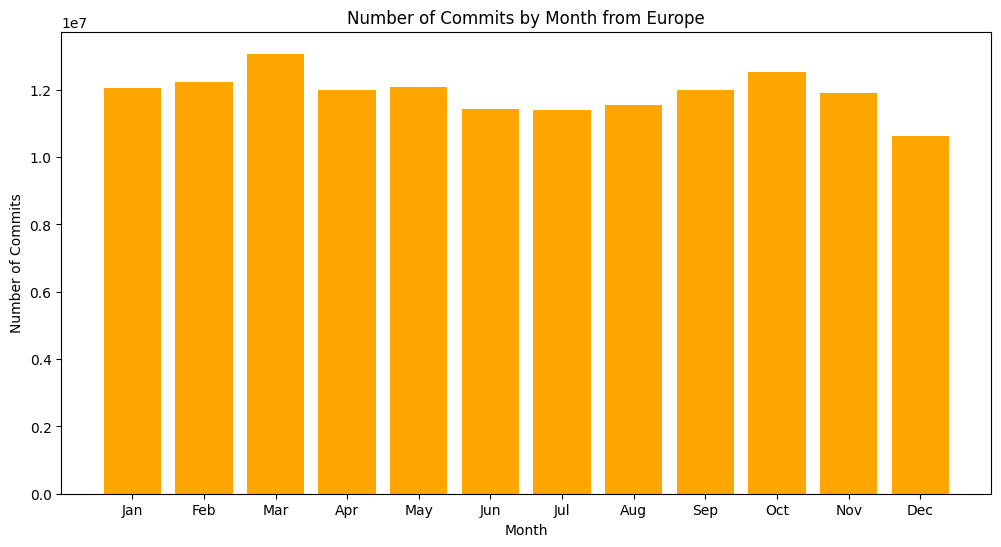

In [23]:
plt.figure(figsize=(12, 6))
plt.bar(commits_by_month_europe_df['commit_month'], commits_by_month_europe_df['commit_count'], color='orange')
plt.title('Number of Commits by Month from Europe')
plt.xlabel('Month')
plt.ylabel('Number of Commits')
plt.xticks(range(12), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.show()

### 예. Asia
아시아 대륙의 월간 커밋 수 플롯:

In [24]:
%%bigquery commits_by_month_asia_df
# Asia
SELECT
  FORMAT_TIMESTAMP('%m', TIMESTAMP_ADD(TIMESTAMP_SECONDS(committer.date.seconds), INTERVAL committer.tz_offset MINUTE)) AS commit_month,
  COUNT(*) AS commit_count
FROM
  `bigquery-public-data.github_repos.commits`
WHERE
  TIMESTAMP_ADD(TIMESTAMP_SECONDS(committer.date.seconds), INTERVAL committer.tz_offset MINUTE) <= CURRENT_TIMESTAMP()
  AND committer.tz_offset BETWEEN 240 AND 720  -- Asian time zones range
GROUP BY
  commit_month
ORDER BY
  commit_month

Query is running:   0%|          |

Downloading:   0%|          |

In [25]:
commits_by_month_asia_df

,commit_month,commit_count
0,01,2617954
1,02,2468114
2,03,2919609
3,04,2929452
4,05,3058115
5,06,2917343
6,07,3005688
7,08,3029970
8,09,2925809
9,10,2894699


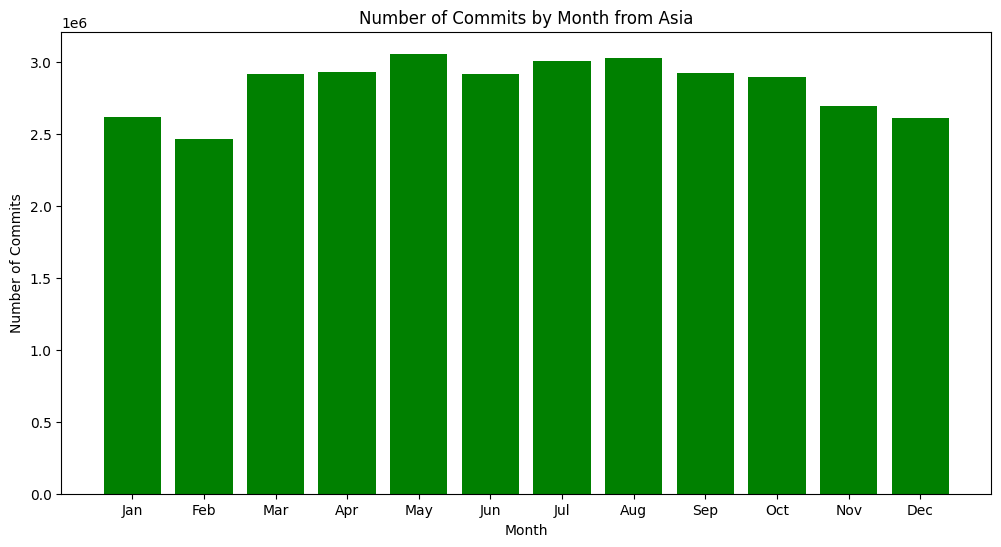

In [26]:
plt.figure(figsize=(12, 6))
plt.bar(commits_by_month_asia_df['commit_month'], commits_by_month_asia_df['commit_count'], color='green')
plt.title('Number of Commits by Month from Asia')
plt.xlabel('Month')
plt.ylabel('Number of Commits')
plt.xticks(range(12), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.show()

### 북미, 유럽, 아시아 대륙의 월간 커밋 수 비교

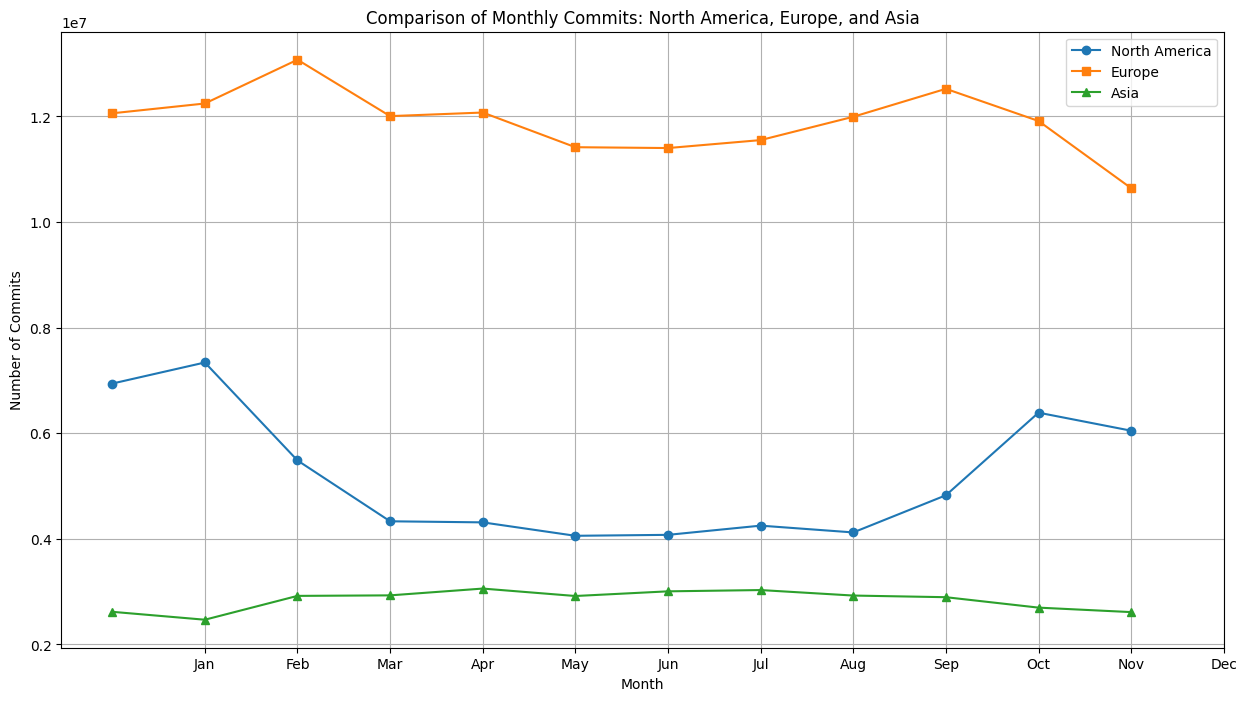

In [27]:
plt.figure(figsize=(15, 8))

# North America
plt.plot(commits_by_month_north_america_df['commit_month'], commits_by_month_north_america_df['commit_count'], label='North America', marker='o')

# Europe
plt.plot(commits_by_month_europe_df['commit_month'], commits_by_month_europe_df['commit_count'], label='Europe', marker='s')

# Asia
plt.plot(commits_by_month_asia_df['commit_month'], commits_by_month_asia_df['commit_count'], label='Asia', marker='^')

plt.title('Comparison of Monthly Commits: North America, Europe, and Asia')
plt.xlabel('Month')
plt.ylabel('Number of Commits')
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.legend()
plt.grid(True)
plt.show()

#### 한계점
1. 커밋의 타임존 오프셋을 기반으로 대륙을 임의로 분류했기 때문에 정확한 지리적 위치를 반영하지 않을 수 있음
2. 각 대륙 내에서도 다양한 시간대가 존재. 특히 아시아는 넓은 범위를 포함하고 있기 때문에 이로 인해 커밋 활동이 실제보다 낮게 보고될 수 있음 

# Coding Conventions

### Tabs vs. Spaces

In [28]:
%%bigquery sample
SELECT COUNT(*) 
FROM `bigquery-public-data.github_repos.files` 
WHERE path LIKE "%.py"

Query is running:   0%|          |

Downloading:   0%|          |

In [29]:
%%bigquery tabs_or_spaces_df
WITH
  lines AS (
  SELECT
    SPLIT(content, '\n') AS line,
    id
  FROM
    `bigquery-public-data.github_repos.sample_contents`
  WHERE
    sample_path LIKE "%.py" )
SELECT
  Indentation,
  COUNT(Indentation) AS number_of_occurence
FROM (
  SELECT
    CASE
        WHEN MIN(CHAR_LENGTH(REGEXP_EXTRACT(flatten_line, r"^\t+")))>=1 THEN 'Tab'
        WHEN MIN(CHAR_LENGTH(REGEXP_EXTRACT(flatten_line, r"^ +")))>=1 THEN 'Space'
        ELSE 'Other'
    END AS Indentation
  FROM
    lines
  CROSS JOIN
    UNNEST(lines.line) AS flatten_line
  WHERE
    REGEXP_CONTAINS(flatten_line, r"^\s+")
  GROUP BY
    id )
GROUP BY
  Indentation
ORDER BY
  number_of_occurence DESC;

Query is running:   0%|          |

Downloading:   0%|          |

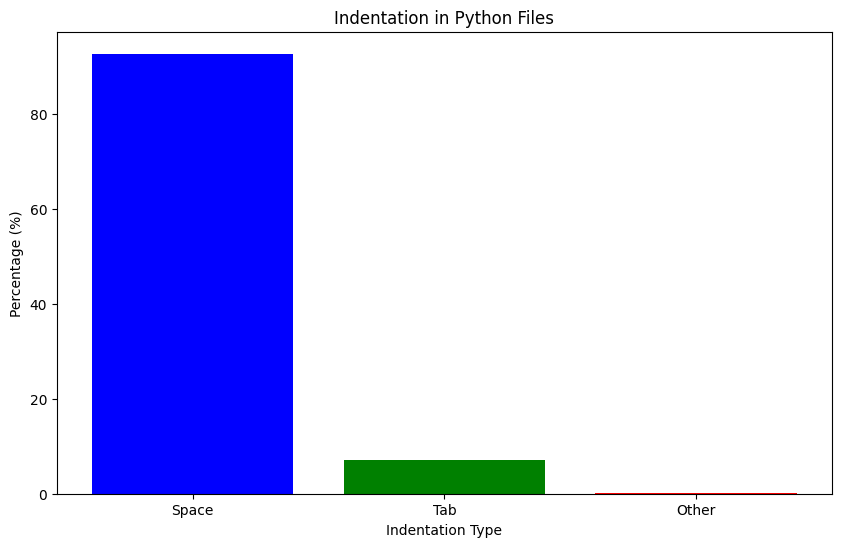

In [30]:
total_occurrences = tabs_or_spaces_df['number_of_occurence'].sum()
tabs_or_spaces_df['percentage'] = (tabs_or_spaces_df['number_of_occurence'] / total_occurrences) * 100

plt.figure(figsize=(10, 6))
plt.bar(tabs_or_spaces_df['Indentation'], tabs_or_spaces_df['percentage'], color=['blue', 'green', 'red'])
plt.title('Indentation in Python Files')
plt.xlabel('Indentation Type')
plt.ylabel('Percentage (%)')
plt.show()

In [31]:
tabs_or_spaces_df

,Indentation,number_of_occurence,percentage
0,Space,75203,92.619095
1,Tab,5843,7.196167
2,Other,150,0.184738


### Single vs. Double Quotes

In [32]:
%%bigquery single_or_double_quotes_df
WITH lines AS (
  SELECT SPLIT(content, '\\n') AS line
  FROM `bigquery-public-data.github_repos.sample_contents`
  WHERE sample_path LIKE "%.py"
)
SELECT 
  IF(REGEXP_CONTAINS(flatten_line, r"'[^']*'"), 'Single Quotes', 'Double Quotes') AS quote_type,
  COUNT(*) AS count
FROM lines
CROSS JOIN UNNEST(lines.line) AS flatten_line
WHERE REGEXP_CONTAINS(flatten_line, r"'[^']*'|\"[^\"]*\"")
GROUP BY quote_type

Query is running:   0%|          |

Downloading:   0%|          |

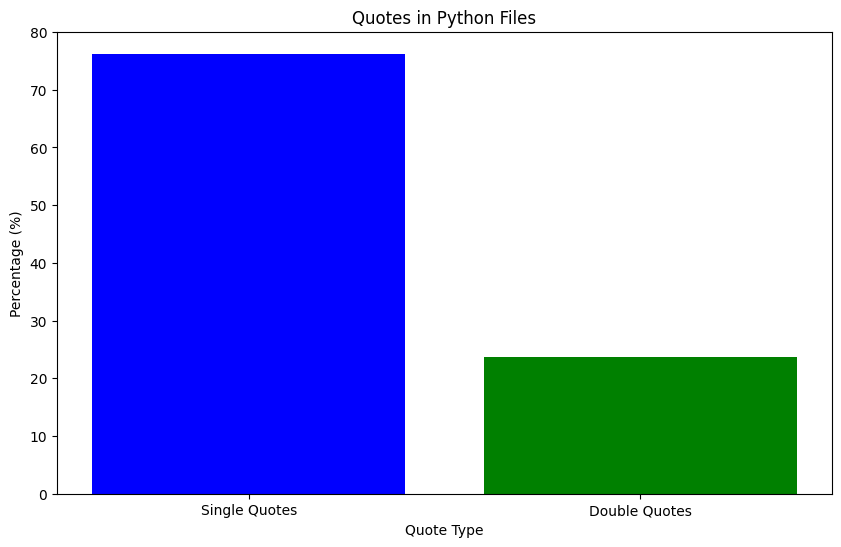

In [33]:
total_count = single_or_double_quotes_df['count'].sum()
single_or_double_quotes_df['percentage'] = (single_or_double_quotes_df['count'] / total_count) * 100

# Plotting as a bar chart
plt.figure(figsize=(10, 6))
plt.bar(single_or_double_quotes_df['quote_type'], single_or_double_quotes_df['percentage'], color=['blue', 'green'])
plt.title('Quotes in Python Files')
plt.xlabel('Quote Type')
plt.ylabel('Percentage (%)')
plt.show()

In [34]:
single_or_double_quotes_df

,quote_type,count,percentage
0,Single Quotes,143390,76.227486
1,Double Quotes,44718,23.772514


### Comma Position

In [35]:
%%bigquery comma_position_df
WITH lines AS (
  SELECT SPLIT(content, '\\n') AS line
  FROM `bigquery-public-data.github_repos.sample_contents`
  WHERE sample_path LIKE "%.py"
)
SELECT 
  IF(REGEXP_CONTAINS(flatten_line, r',\s*$'), 'Last Comma', 'First Comma') AS comma_position,
  COUNT(*) AS count
FROM lines
CROSS JOIN UNNEST(lines.line) AS flatten_line
WHERE REGEXP_CONTAINS(flatten_line, r',\s*$') OR REGEXP_CONTAINS(flatten_line, r'^\s*,')
GROUP BY comma_position

Query is running:   0%|          |

Downloading:   0%|          |

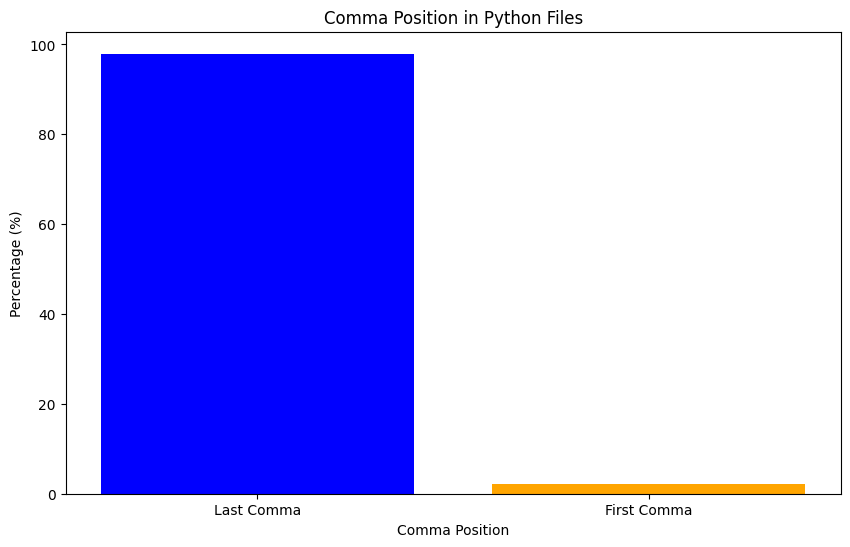

In [36]:
total_count = comma_position_df['count'].sum()
comma_position_df['percentage'] = (comma_position_df['count'] / total_count) * 100

# Plotting as a bar chart
plt.figure(figsize=(10, 6))
plt.bar(comma_position_df['comma_position'], comma_position_df['percentage'], color=['blue', 'orange'])
plt.title('Comma Position in Python Files')
plt.xlabel('Comma Position')
plt.ylabel('Percentage (%)')
plt.show()

In [37]:
comma_position_df

,comma_position,count,percentage
0,Last Comma,3181,97.937192
1,First Comma,67,2.062808


### Constant Naming Styles

In [38]:
%%bigquery constant_naming_styles_df
WITH lines AS (
  SELECT SPLIT(content, '\\n') AS line
  FROM `bigquery-public-data.github_repos.sample_contents`
  WHERE sample_path LIKE "%.py"
)
SELECT 
  CASE
    WHEN REGEXP_CONTAINS(flatten_line, r'^\s*[A-Z][a-zA-Z0-9]*\s*=\s*') THEN 'PascalCase'
    WHEN REGEXP_CONTAINS(flatten_line, r'^\s*[A-Z0-9_]+\s*=\s*') THEN 'ALL_CAPS_WITH_UNDERSCORE'
    ELSE 'Others'
  END AS naming_style,
  COUNT(*) AS count
FROM lines
CROSS JOIN UNNEST(lines.line) AS flatten_line
WHERE REGEXP_CONTAINS(flatten_line, r'^\s*[A-Z][a-zA-Z0-9_]*\s*=\s*')
GROUP BY naming_style

Query is running:   0%|          |

Downloading:   0%|          |

In [39]:
constant_naming_styles_df

,naming_style,count
0,PascalCase,312
1,ALL_CAPS_WITH_UNDERSCORE,134
2,Others,8


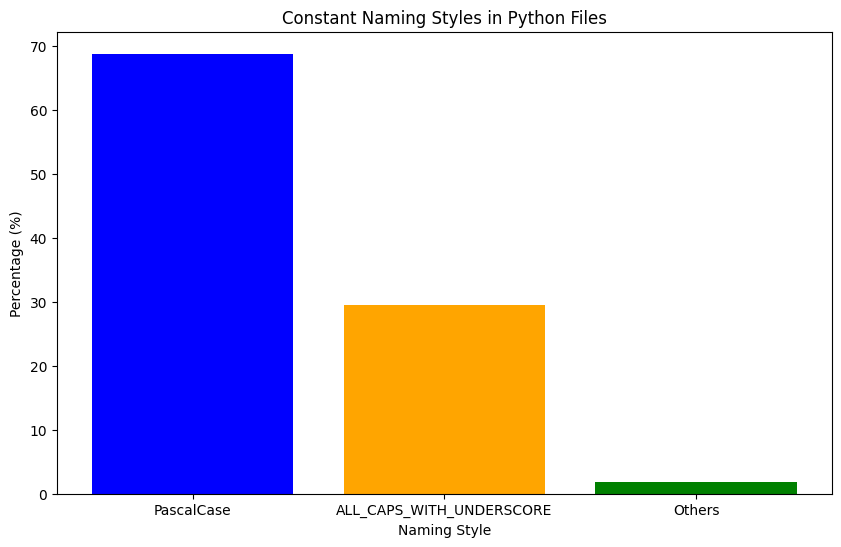

In [40]:
total_count = constant_naming_styles_df['count'].sum()
constant_naming_styles_df['percentage'] = (constant_naming_styles_df['count'] / total_count) * 100

plt.figure(figsize=(10, 6))
plt.bar(constant_naming_styles_df['naming_style'], constant_naming_styles_df['percentage'], color=['blue', 'orange', 'green'])
plt.title('Constant Naming Styles in Python Files')
plt.xlabel('Naming Style')
plt.ylabel('Percentage (%)')
plt.show()